<a href="https://colab.research.google.com/github/sidgan/ETCI-2021-Competition-on-Flood-Detection/blob/main/notebooks/Data_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Important links

* https://nasa-impact.github.io/etci2021/
* https://competitions.codalab.org/competitions/30440

## Data Collection

In [ ]:
!gdown --id 14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr

Downloading...
From: https://drive.google.com/uc?id=14HqNW5uWLS92n7KrxKgDwUTsSEST6LCr
To: /content/train.zip
3.23GB [00:22, 144MB/s]


In [ ]:
!unzip -qq train.zip
!rm -rf train.zip

In [ ]:
!ls -lh train | head -10

total 124K
drwxr-x--- 3 root root 4.0K Mar 13 01:22 bangladesh_20170314t115609
drwxr-x--- 3 root root 4.0K Mar 17 22:49 bangladesh_20170606t115613
drwxr-x--- 3 root root 4.0K Mar 17 22:49 bangladesh_20170712t115615
drwxr-x--- 3 root root 4.0K Mar 11 03:50 nebraska_20170108t002112
drwxr-x--- 3 root root 4.0K Mar 17 22:49 nebraska_20170213t002121
drwxr-x--- 3 root root 4.0K Mar 17 22:49 nebraska_20170309t002110
drwxr-x--- 3 root root 4.0K Mar 17 22:49 nebraska_20170402t002111
drwxr-x--- 3 root root 4.0K Mar 17 22:49 nebraska_20170508t002113
drwxr-x--- 3 root root 4.0K Mar 17 22:49 nebraska_20170520t002113


In [ ]:
!ls -lh train/bangladesh_20170314t115609/tiles | head -10

total 564K
drwxr-x--- 3 root root 136K Mar 11 03:49 flood_label
drwxr-x--- 2 root root 144K Mar 11 03:49 vh
drwxr-x--- 2 root root 148K Mar 11 03:49 vv
drwxr-x--- 2 root root 136K Mar 11 03:49 water_body_label


In [ ]:
!ls -lh train/bangladesh_20170314t115609/tiles/flood_label | head -10

total 8.2M
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-0.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-10.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-11.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-12.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-13.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-14.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-15.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-16.png
-rw-r----- 1 root root  270 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-17.png


In [ ]:
!ls -lh train/bangladesh_20170314t115609/tiles/vh | head -10

total 95M
-rw-r----- 1 root root  670 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-0_vh.png
-rw-r----- 1 root root  712 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-10_vh.png
-rw-r----- 1 root root  718 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-11_vh.png
-rw-r----- 1 root root  722 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-12_vh.png
-rw-r----- 1 root root  729 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-13_vh.png
-rw-r----- 1 root root  729 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-14_vh.png
-rw-r----- 1 root root  739 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-15_vh.png
-rw-r----- 1 root root  739 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-16_vh.png
-rw-r----- 1 root root  742 Mar 11 03:49 bangladesh_20170314t115609_x-0_y-17_vh.png


From [here](https://nasa-impact.github.io/etci2021/#semantic-labels): 

> The provided training data is split across 29 root folders named \<region>\_\<datetime>*, region being the region and datetime being the date and time of the flood event. Each root folder includes 4 sub-folders: vv, vh, water_body_label and flood_label with 2,068 files each. vv and vh correspond to the satellite images listed earlier and images in the flood_label and water_body_label folder provide reference ground truth.

## Imports

In [ ]:
from imutils import paths
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import re
import os

## Investigation

In [ ]:
all_image_paths = list(paths.list_images("train"))
print(f"Total images: {int(len(all_image_paths)/2)}")

Total images: 66812


So, we have 33,406 satellite images and the rest are binary segmentation maps. 

For a given image id (e.g. `nebraska_20170309t002110`), its correspnding ground-truths i.e. the segmentation maps are present in either of these two folders: `water_body_label` and `flood_label`. Let's write a few utility functions for knowing the dataset in a better way. 

**How many unique image IDs are there?**

In [ ]:
image_ids = {path.split("/")[1] for path in all_image_paths}
print(len(image_ids))

31


Now, let's investigate how are these IDs distributed? **Do all the IDs have the same amount of images present?**

In [ ]:
def get_image_paths(image_id):
    flood_image_root = os.path.join("train", image_id, "tiles", "flood_label")
    water_body_root = os.path.join("train", image_id, "tiles", "water_body_label")
    vh_root = os.path.join("train", image_id, "tiles", "vh")
    vv_root = os.path.join("train", image_id, "tiles", "vv")

    flood_image_paths = list(paths.list_images(flood_image_root))
    water_body_paths = list(paths.list_images(water_body_root))
    vh_image_paths = list(paths.list_images(vh_root))
    vv_image_paths = list(paths.list_images(vv_root))

    return flood_image_paths, water_body_paths,\
        vh_image_paths, vv_image_paths

In [ ]:
distribution_dict = {}

for id in tqdm(image_ids):
    distribution_dict[id] = {}
    flood_image_paths, water_body_paths, vh_image_paths, vv_image_paths = \
        get_image_paths(id)

    distribution_dict[id]["flood_images"] = len(flood_image_paths)
    distribution_dict[id]["water_body_images"] = len(water_body_paths)
    distribution_dict[id]["vh_images"] = len(vh_image_paths)
    distribution_dict[id]["vv_images"] = len(vv_image_paths)

distribution_df = pd.DataFrame.from_dict(distribution_dict).T
assert len(distribution_df) == len(image_ids)
distribution_df

100%|██████████| 31/31 [00:00<00:00, 69.67it/s]


flood_images  ...  vv_images
northal_20190712t234656              936  ...        936
northal_20190829t234659              936  ...        936
northal_20190302t234651              936  ...        936
nebraska_20170731t002118            1008  ...       1008
nebraska_20170402t002111            1008  ...       1008
nebraska_20170213t002121            1008  ...       1008
northal_20190407t234651              936  ...        936
nebraska_20171210t002119            1008  ...       1008
northal_20190525t234653              936  ...        936
nebraska_20170929t002120            1008  ...       1008
bangladesh_20170314t115609          2072  ...       2068
nebraska_20170601t002114            1161  ...       1161
nebraska_20170108t002112             984  ...        984
northal_20190513t234653              936  ...        936
northal_20190606t234654              936  ...        936
nebraska_20171116t002120            1008  ...       1008
nebraska_20171222t002118            1008  ...       1008
nebraska_20170520t002113            1008  ...       1008
bangladesh_20170712t115615          2068  ...       2068
northal_20190724t234657              936  ...        936
northal_20190630t234655              936  ...        936
northal_20191227t234659              936  ...        936
northal_20190910t234659              936  ...        936
northal_20190419t234652              936  ...        936
northal_20191004t234700              936  ...        936
northal_20190805t234658              936  ...        936
nebraska_20170309t002110            1008  ...       1008
northal_20191121t234700              936  ...        936
northal_20190618t234654              936  ...        936
bangladesh_20170606t115613          2068  ...       2068
nebraska_20170508t002113            1008  ...       1008

[31 rows x 4 columns]

No huge distribution skews noticed. But for **`bangladesh_20170314t115609`** there is a mismatch between the number of flood image maps and the number of VV images.

## Visualization

Now, let's write a utility function that would return the images belonging to the format - `<region>_<datetime>*_x-*_y-*.png`. 

It seems like the VV images should be used for predicting flood levels and VH images should be used for predicting water body levels.

<p align="center">
<img src=https://i.ibb.co/mCZp6X4/image.png></ing>
</p>

However, 

> We expect participants to provide a binary segmentation of the region of interest (ROI), (i.e. 256x256 pixels) as a numpy array with the byte (uint8) data type:
**1: Flood region, 0: Not flood region**.

In [ ]:
# https://stackoverflow.com/a/2669120/7636462
def sorted_nicely(l): 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [ ]:
all_image_paths = sorted_nicely(all_image_paths)

vv_image_paths = [path for path in all_image_paths if ("vv" in path) and ("ipynb_checkpoints" not in path)]
flood_image_paths = [path for path in all_image_paths if ("flood" in path) and ("ipynb_checkpoints" not in path)]
vh_image_paths = [path for path in all_image_paths if ("vh" in path) and ("ipynb_checkpoints" not in path)]
water_body_label_paths = [path for path in all_image_paths if ("water" in path) and ("ipynb_checkpoints" not in path)]

len(flood_image_paths), len(vv_image_paths), len(vh_image_paths), len(water_body_label_paths)

(33405, 33405, 33405, 33405)

In [ ]:
all_image_paths[0]

'train/bangladesh_20170314t115609/tiles/flood_label/.ipynb_checkpoints/bangladesh_20170314t115609_x-1_y-25-checkpoint.png'

What is `.ipynb_checkpoints` doing here? 😨

In [ ]:
# Verify if we have maintained the order
flood_image_paths[:5], vv_image_paths[:5]

(['train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-0.png',
  'train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-1.png',
  'train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-2.png',
  'train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-3.png',
  'train/bangladesh_20170314t115609/tiles/flood_label/bangladesh_20170314t115609_x-0_y-4.png'],
 ['train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-0_vv.png',
  'train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-1_vv.png',
  'train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-2_vv.png',
  'train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-3_vv.png',
  'train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-0_y-4_vv.png'])

In [ ]:
water_body_label_paths[:5], vh_image_paths[:5]

(['train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-0.png',
  'train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-1.png',
  'train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-2.png',
  'train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-3.png',
  'train/bangladesh_20170314t115609/tiles/water_body_label/bangladesh_20170314t115609_x-0_y-4.png'],
 ['train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-0_vh.png',
  'train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-1_vh.png',
  'train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-2_vh.png',
  'train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-3_vh.png',
  'train/bangladesh_20170314t115609/tiles/vh/bangladesh_20170314t115609_x-0_y-4_vh.png'])

In [ ]:
def get_image_id(filename):
    return filename.split("/")[1]

In [ ]:
def show_all_four_images(filenames, titles):
    plt.figure(figsize=(20, 10))
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
        
    plt.suptitle(get_image_id(filenames[0]), size=16)
    columns = 4
    
    for i, image in enumerate(images):
        ax = plt.subplot(len(images)/ columns + 1, columns, i + 1)
        ax.set_title(titles[i])
        plt.imshow(image)

    plt.show()

In [ ]:
regex = r"_x-\d+_y-\d+"
compiler = re.compile(regex)

def get_intensity(path):
    return compiler.search(path).group()

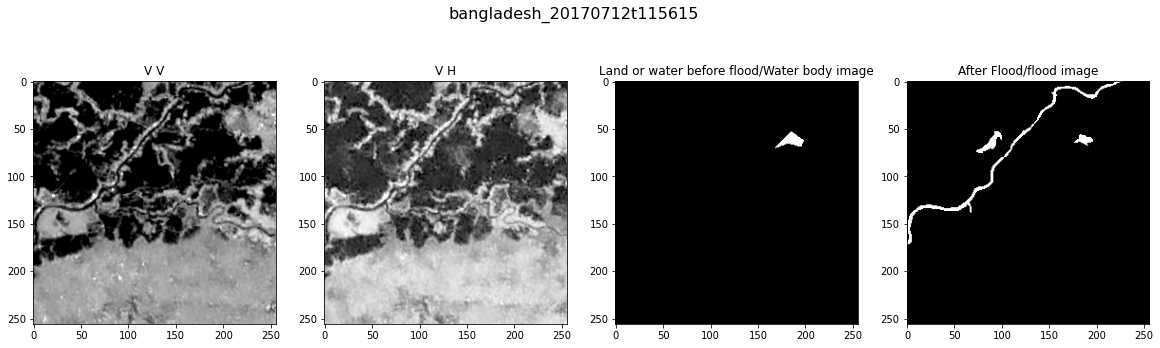

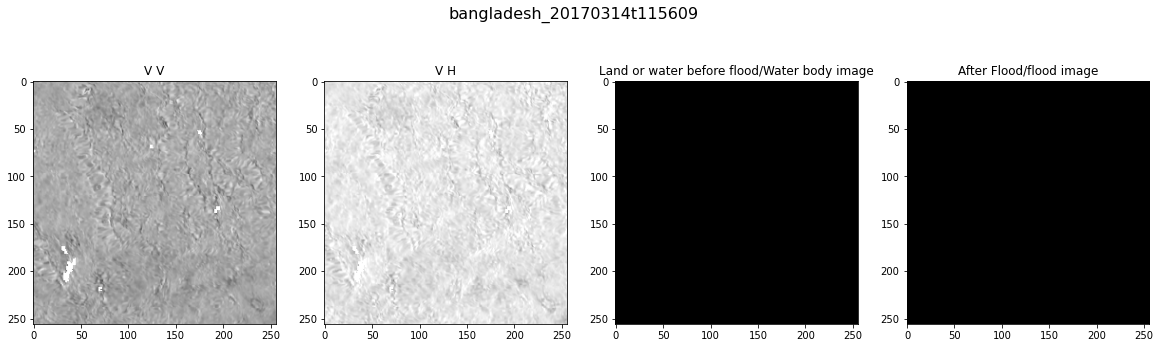

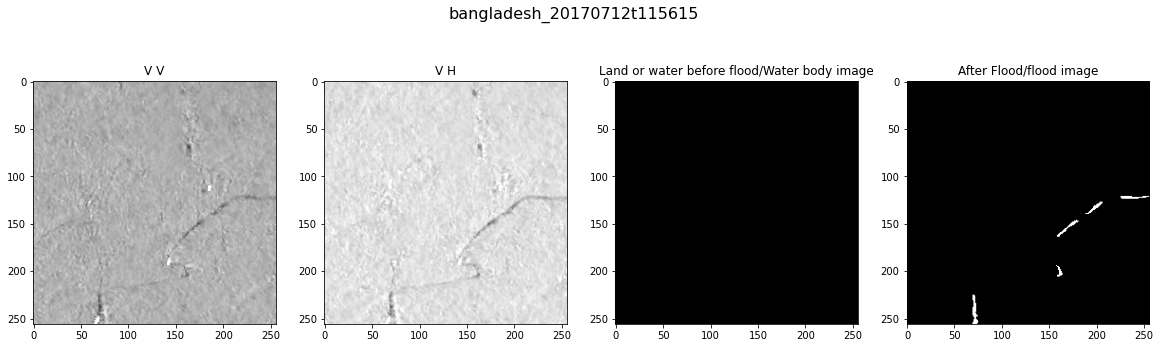

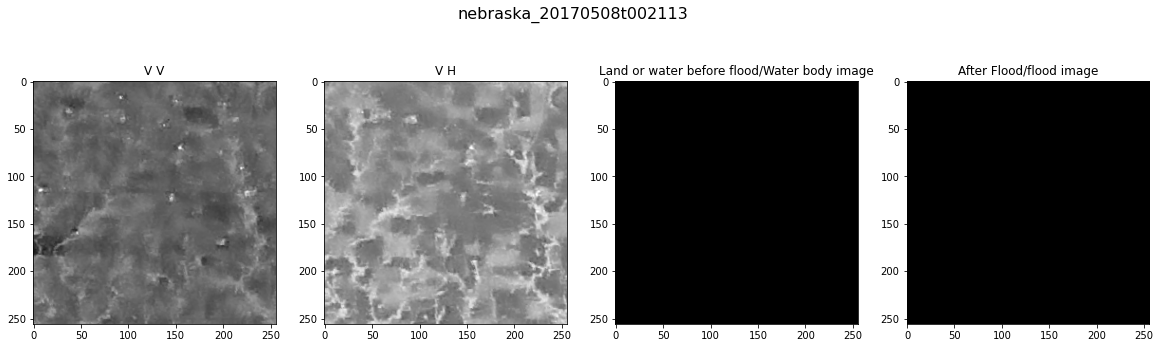

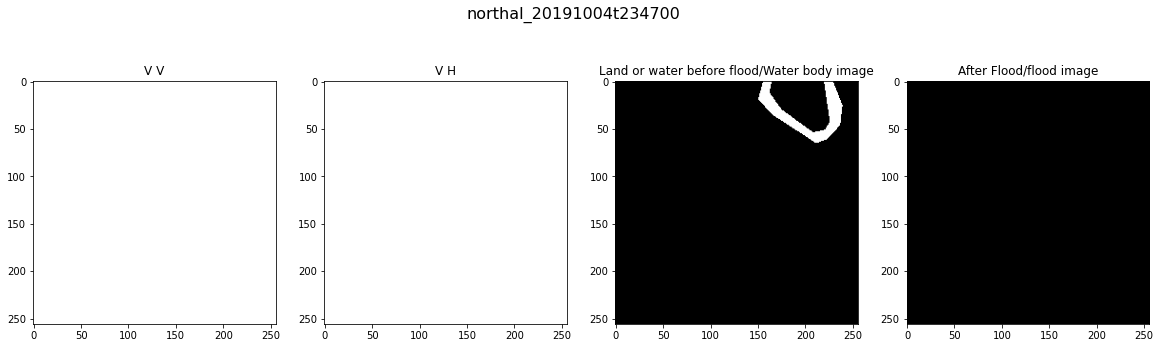

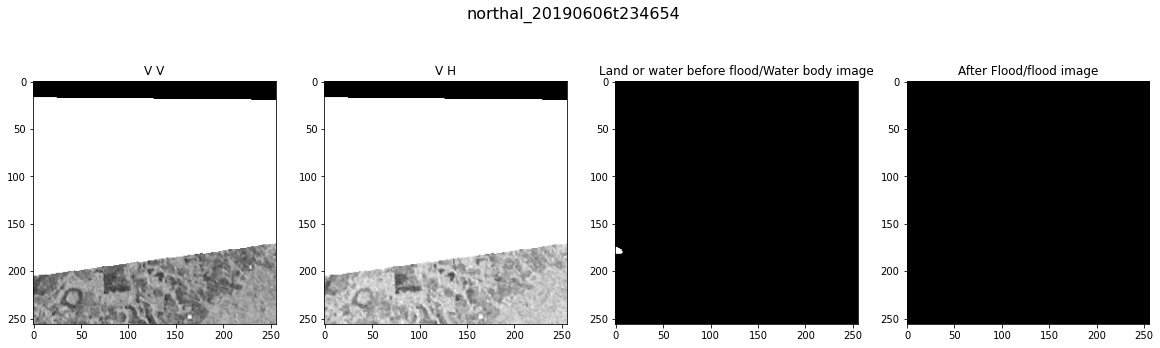

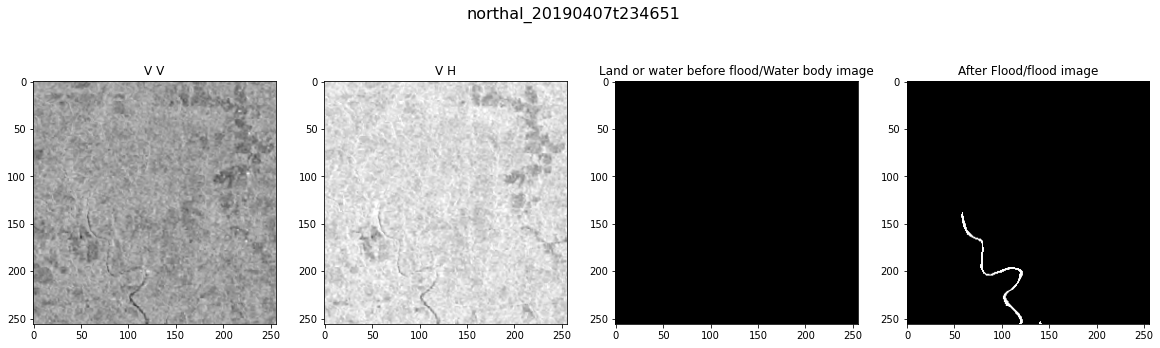

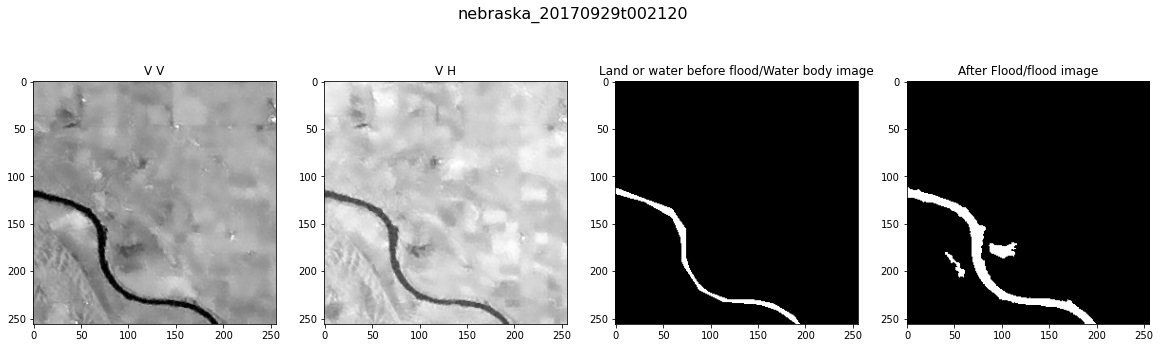

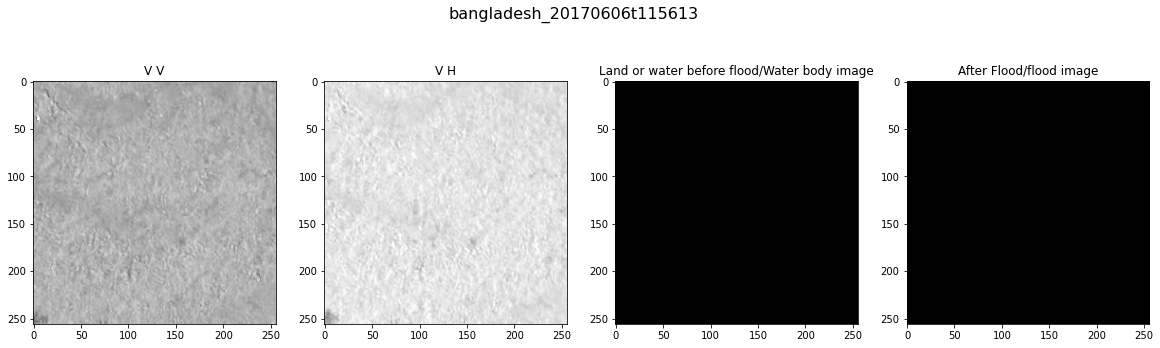

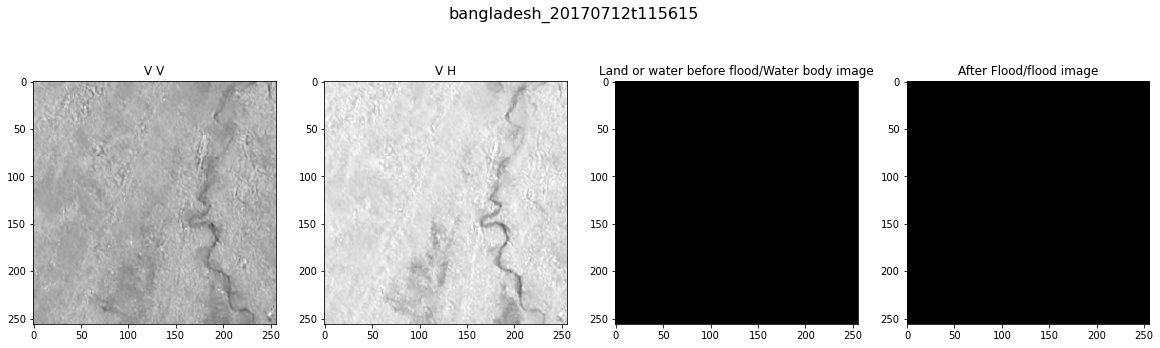

In [ ]:
import random

titles = ["V V","V H" , "Land or water before flood/Water body image" ,"After Flood/flood image"]

random_index =  random.sample(range(0, len(vv_image_paths)), 10) 
for i in random_index:
    # The assertions make sure we are operating on the right pairs
    assert  get_intensity(vv_image_paths[i]) == get_intensity(flood_image_paths[i])
    assert  get_intensity(vh_image_paths[i]) == get_intensity(water_body_label_paths[i])
    show_all_four_images([vv_image_paths[i], vh_image_paths[i],  
                          water_body_label_paths[i], flood_image_paths[i] ] , titles)

**Some noise found (from an earlier iteration)**:

* https://ibb.co/m6x9f1S
* https://ibb.co/rfWtJy7

How in an all-white image, any segmentation map is present? 

### Displaying the RGB composite

From [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/product-overview/polarimetry):

> The composite RGB (colour) image on the right was created using the VV channel for red, VH channel for green and the ratio $|VV| / |VH|$ for blue.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


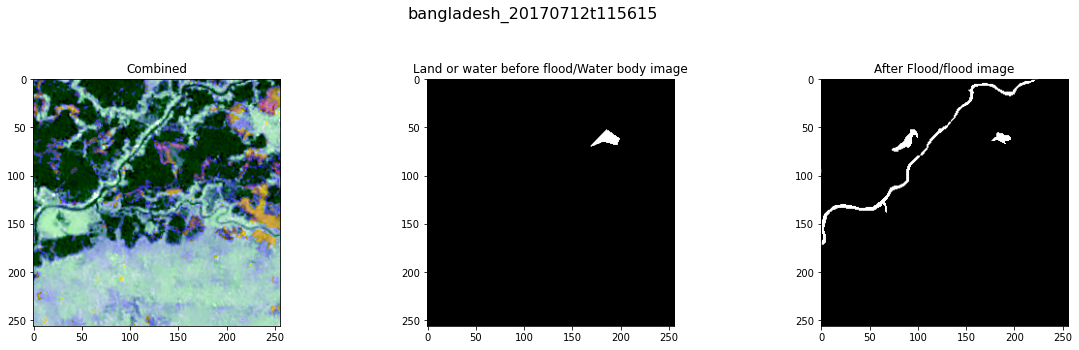

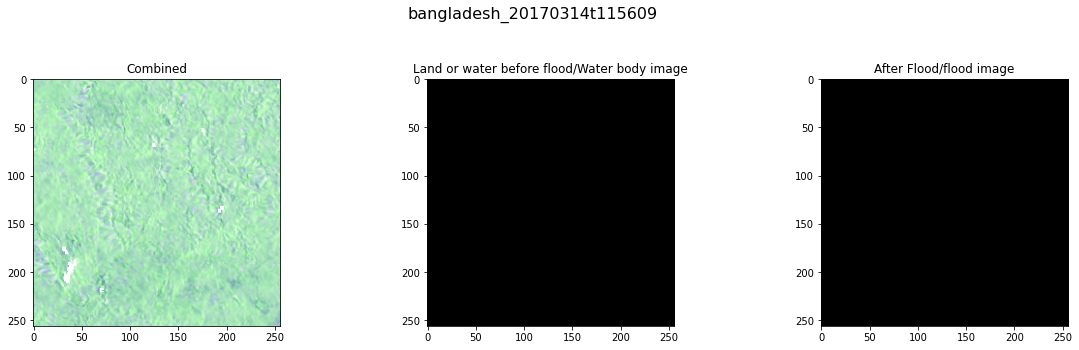

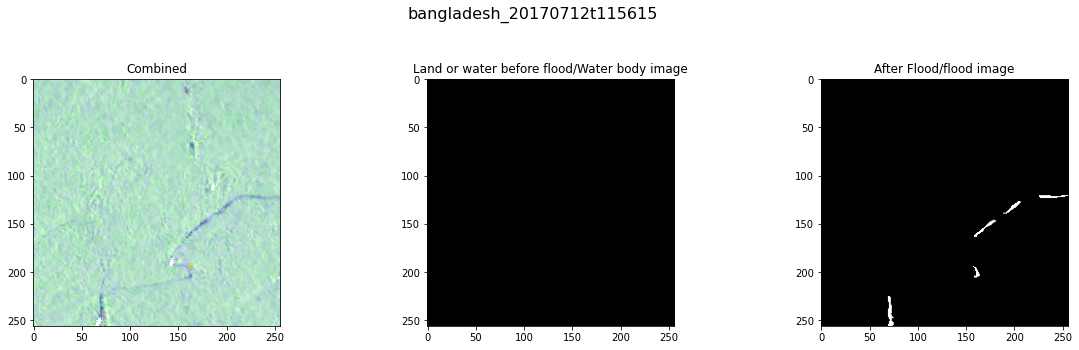

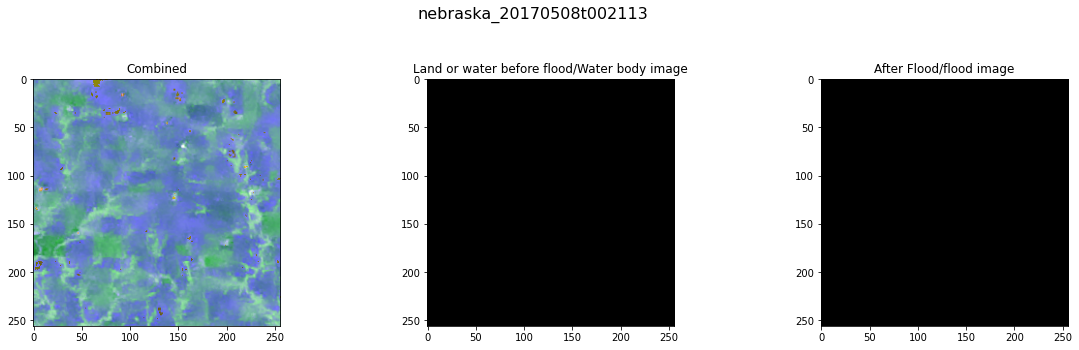

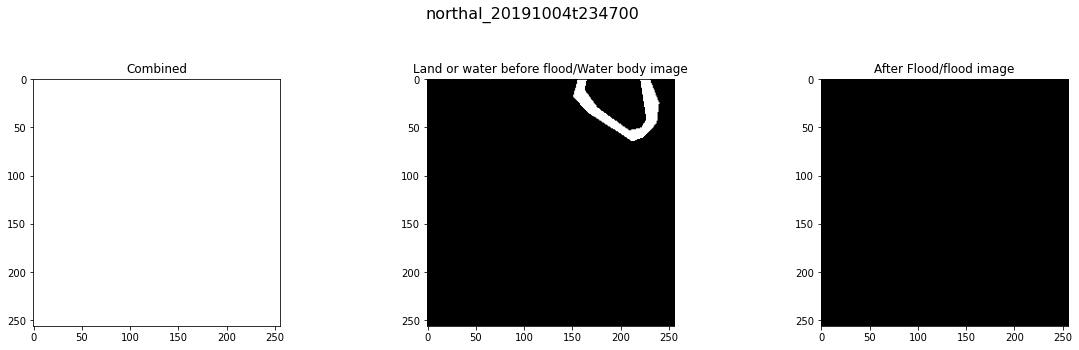

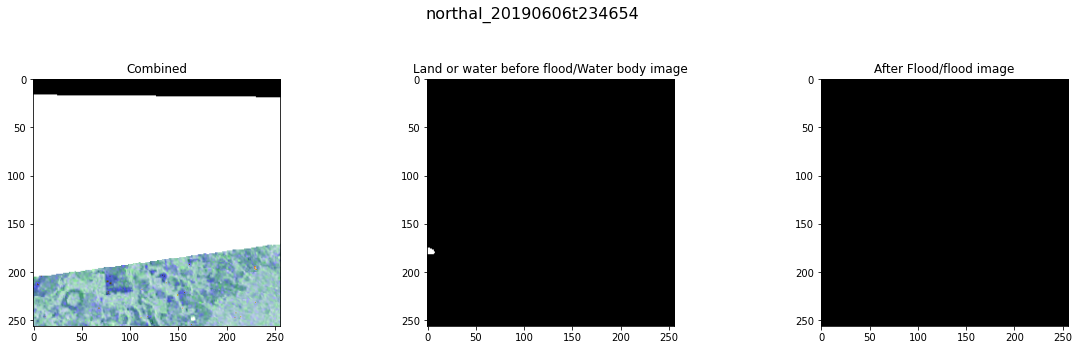

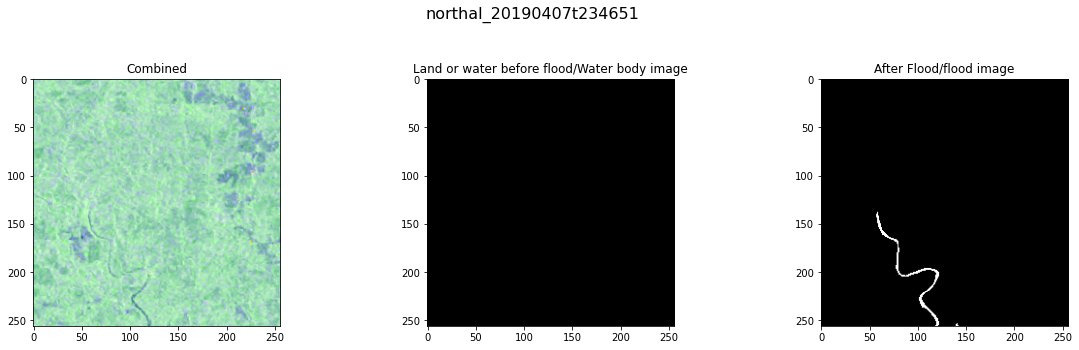

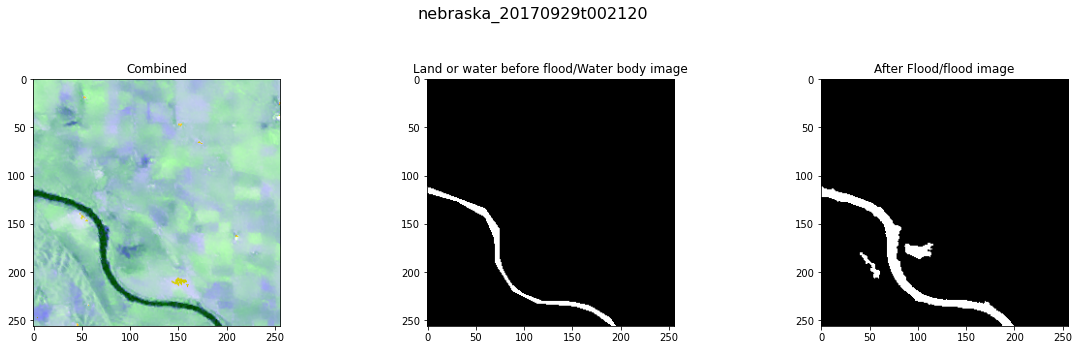

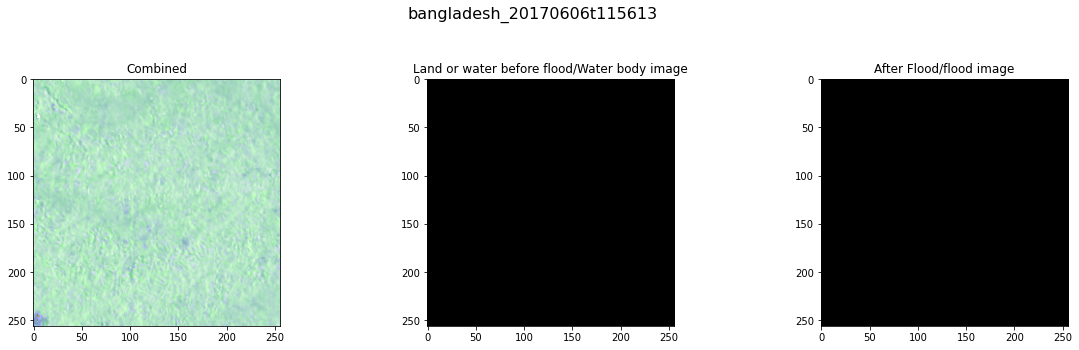

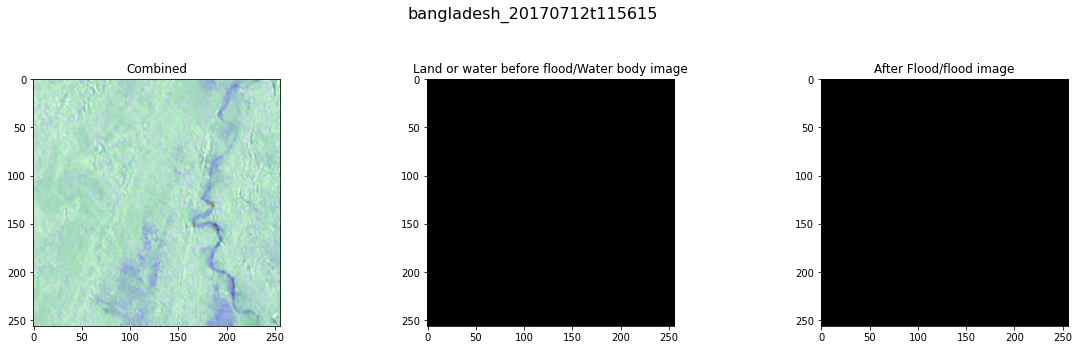

In [ ]:
from PIL import Image

def show_all_combined_images(i, titles):
    columns = 3

    red, _ , _  = Image.open(vv_image_paths[i]).split()
    red = np.asarray(red)
    _, green, _  = Image.open(vh_image_paths[i]).split()
    green = np.asarray(green)

    blue = np.abs(red) / np.abs(green) 
    blue = (blue * 255).astype(np.uint8)
    rgb = Image.fromarray(np.dstack((red,green,blue)))

    images = [rgb]
    images.append(mpimg.imread(water_body_label_paths[i]))
    images.append(mpimg.imread(flood_image_paths[i]))

    plt.figure(figsize=(20, 10))
    plt.suptitle(get_image_id(vv_image_paths[i]), size=16)
    for i, image in enumerate(images):
        ax = plt.subplot(len(images)/ columns + 1, columns, i + 1)
        ax.set_title(titles[i])
        plt.imshow(image)


titles = ["Combined" , "Land or water before flood/Water body image" ,"After Flood/flood image"]
for i in random_index:
    show_all_combined_images(i , titles)

## Observations

* We need to be careful about the way we would shuffle the samples. We likely wouldn't want to just randomly shuffle them. Because if we do so then the continual order of samples for a particular region and timestamp would get broken. 
* We also cannot randomly sample data points for our local validation set. It's much like predicting the next frame for a given sequence of frames. We would want to train models on a sequence of *ordered* frames and use that to infer the next one. 
* Can we simply discard the blank images (all white ones under `Combined` and their respective labels)? I don't see any point in keeping them. 

## Some preprocessing 

Referred from this [video](https://youtu.be/derOXkPCH80). A PDF is present [here](http://step.esa.int/docs/tutorials/S1TBX%20SAR%20Basics%20Tutorial.pdf). 

### Speckle removal

In [ ]:
# https://stackoverflow.com/a/39786527/7636462
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size=20):
    img_mean = uniform_filter(img, (size, size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

In [ ]:
random_index =  random.sample(range(0, len(vv_image_paths)), 10) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


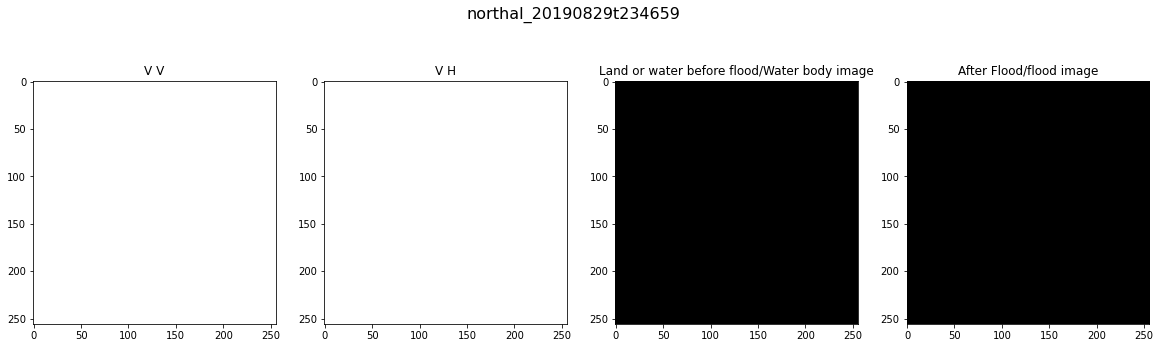

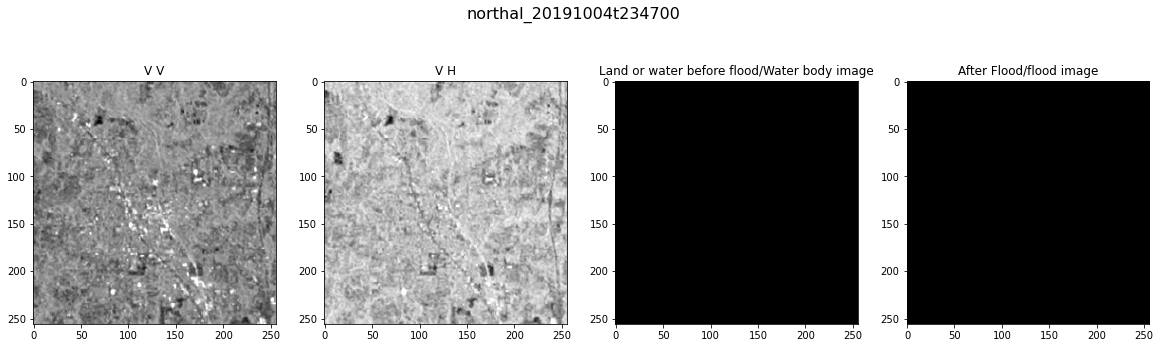

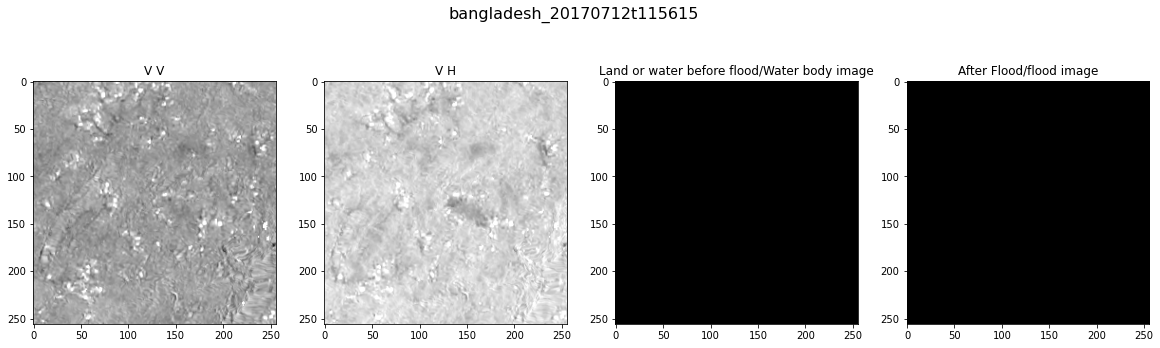

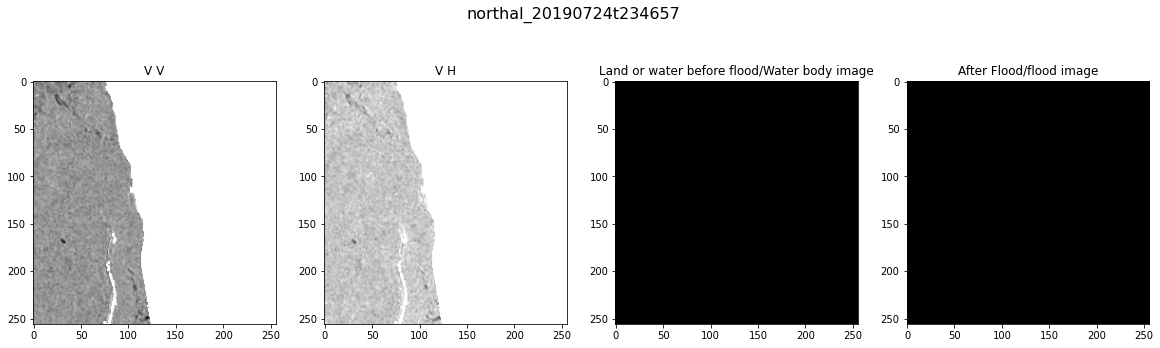

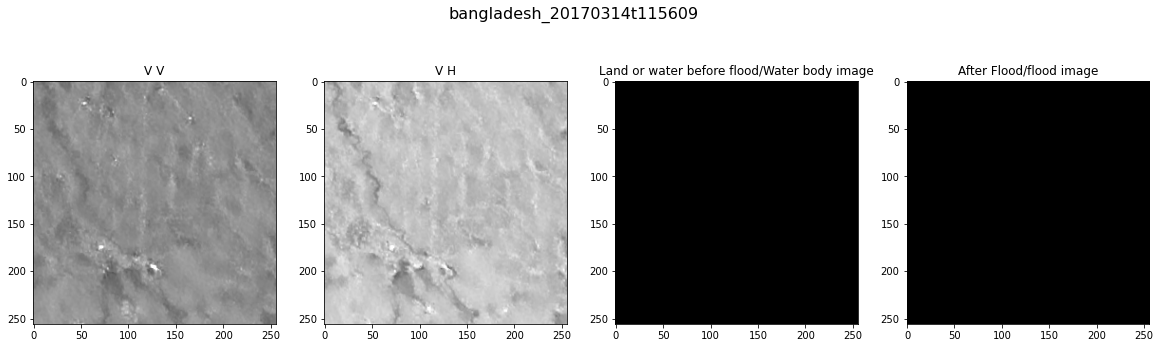

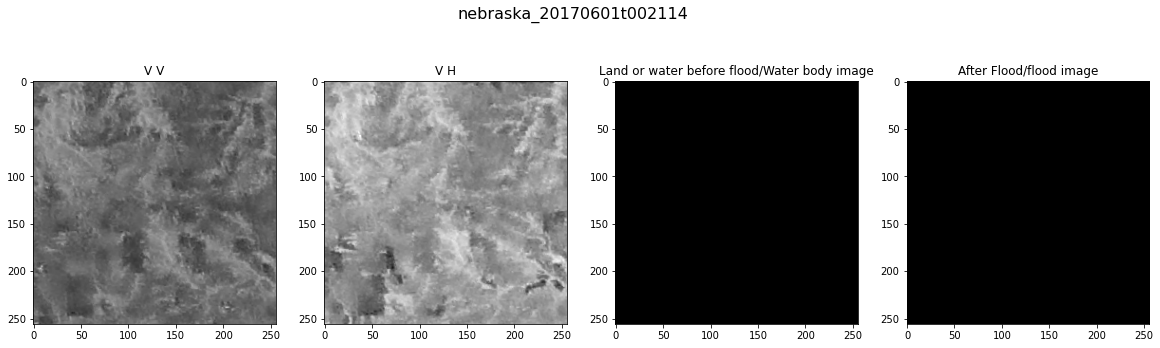

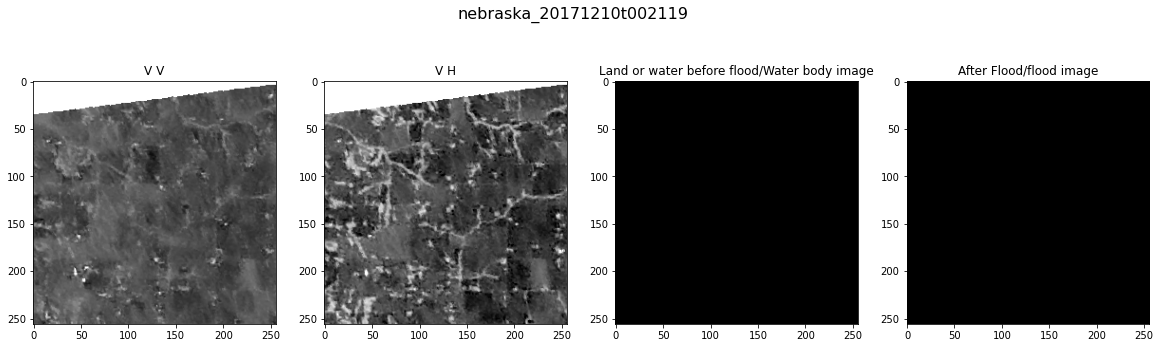

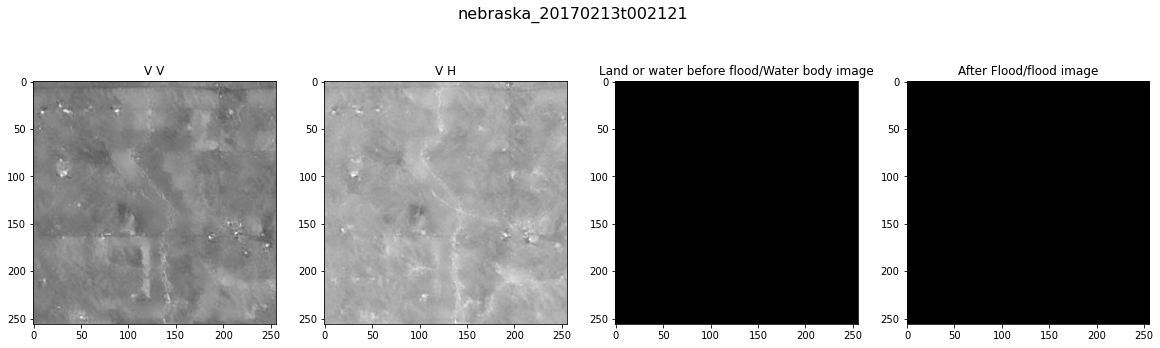

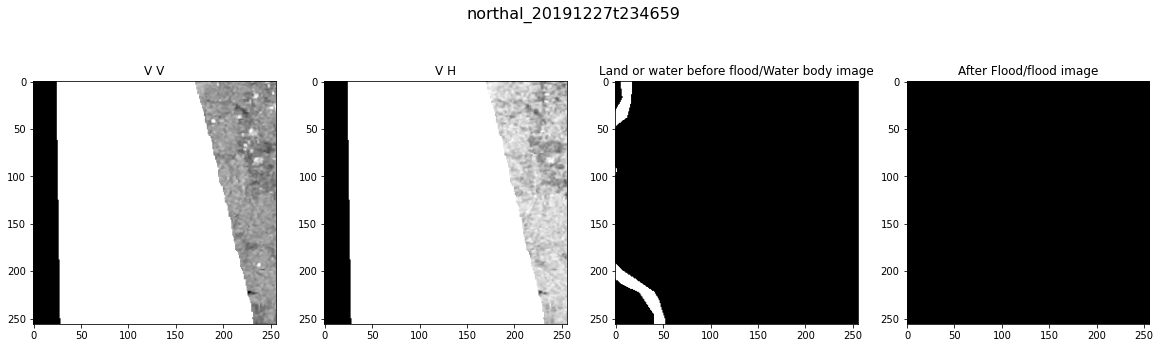

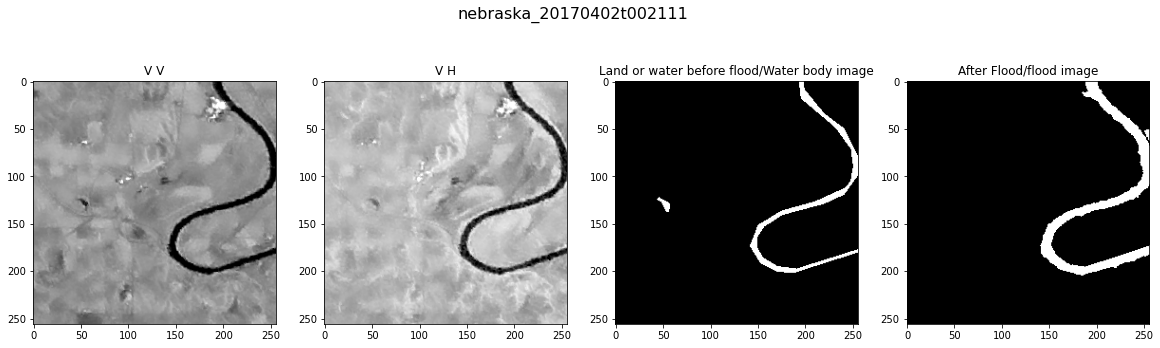

In [ ]:
# With Speckle Removal

def show_all_four_images(filenames, titles, speckle=False):
    plt.figure(figsize=(20, 10))
    images = []
    for filename in filenames:
        image = mpimg.imread(filename)
        if speckle:
            lee_filter(image)
        images.append(image)
        
    plt.suptitle(get_image_id(filenames[0]), size=16)
    columns = 4
    
    for i, image in enumerate(images):
        ax = plt.subplot(len(images)/ columns + 1, columns, i + 1)
        ax.set_title(titles[i])
        plt.imshow(image)

    plt.show()

titles = ["V V","V H" , "Land or water before flood/Water body image" ,"After Flood/flood image"]

for i in random_index:
    show_all_four_images([vv_image_paths[i], vh_image_paths[i],  
                          water_body_label_paths[i], flood_image_paths[i] ] , titles, True)

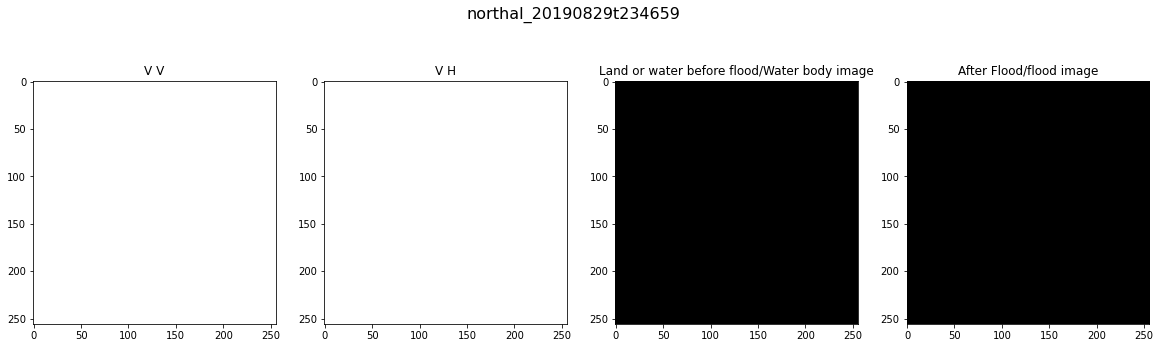

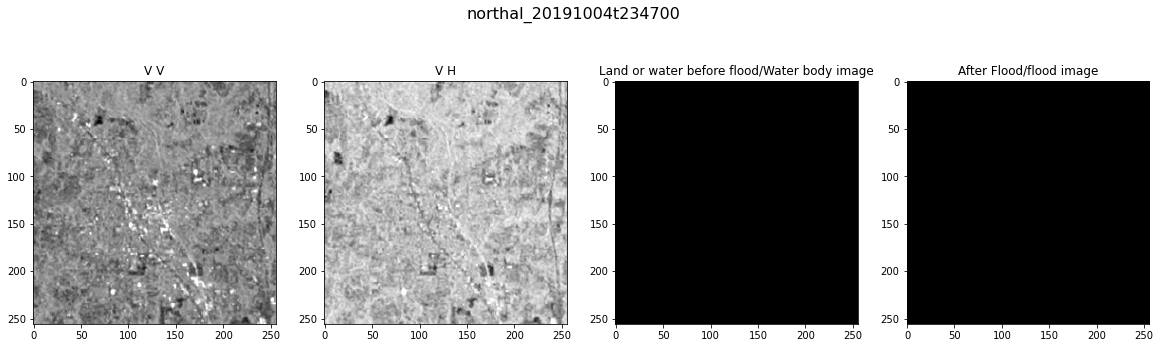

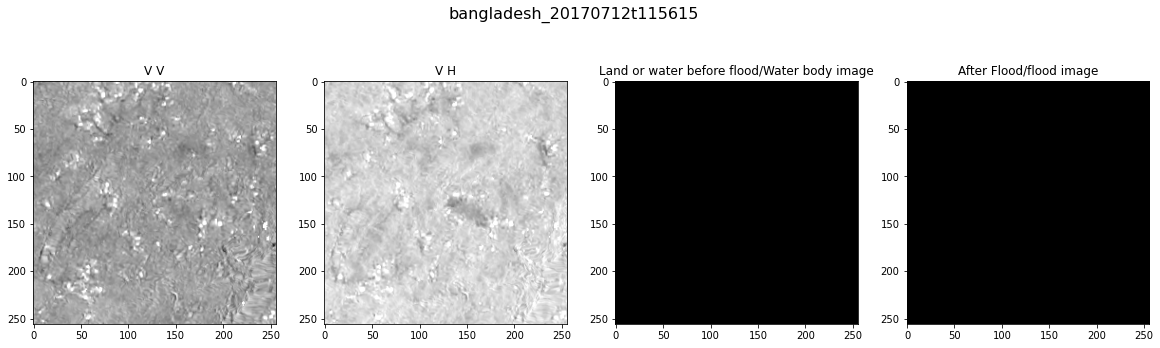

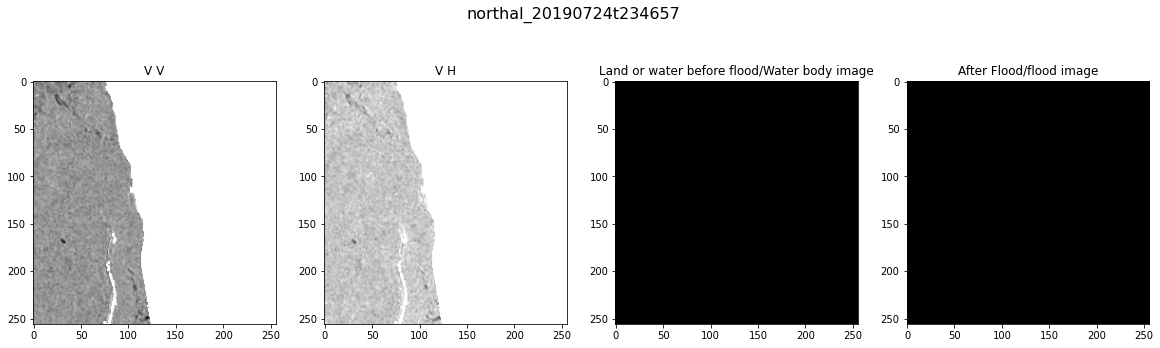

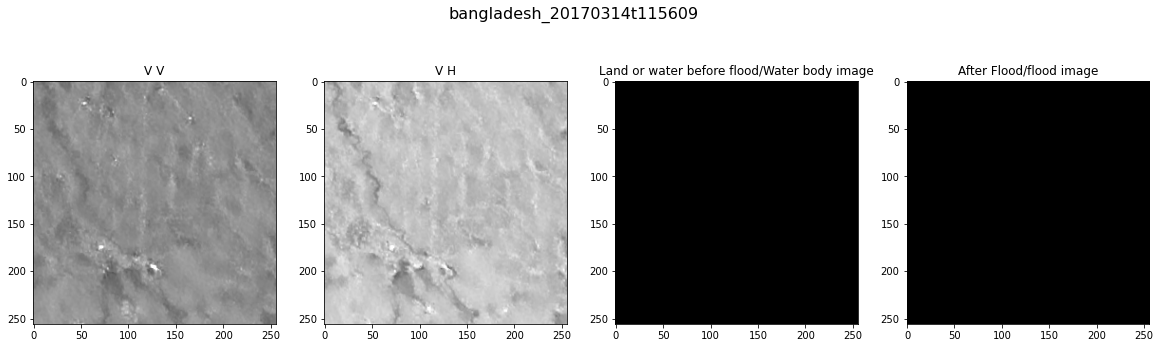

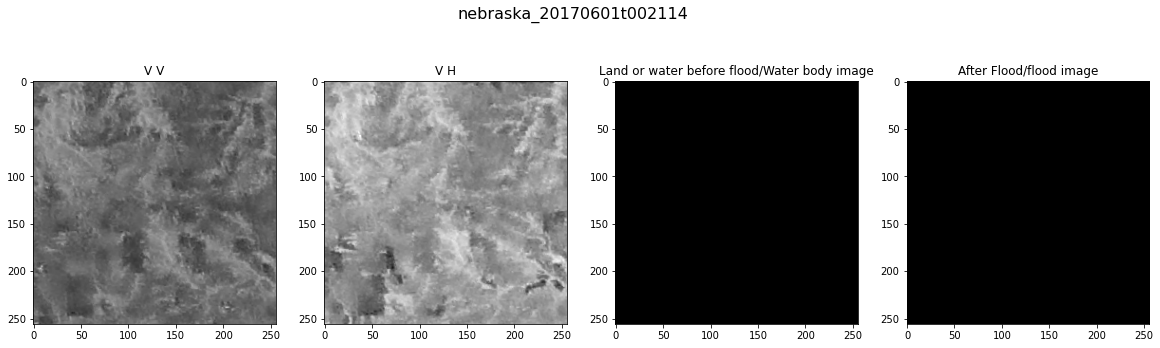

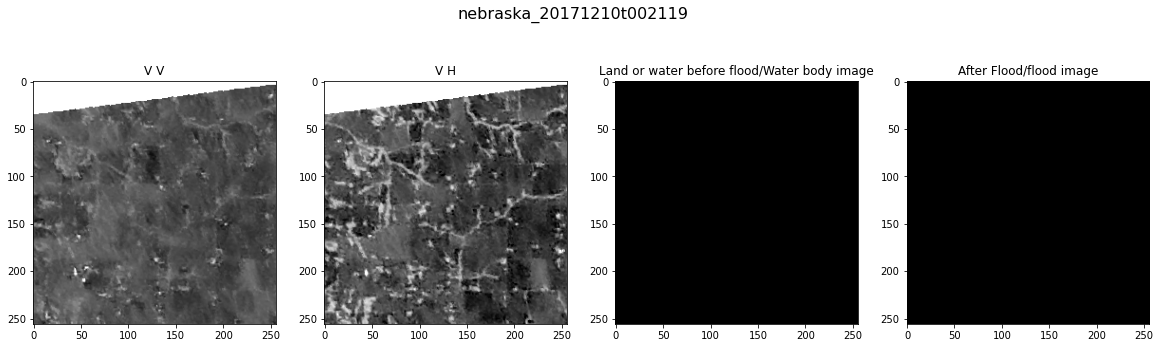

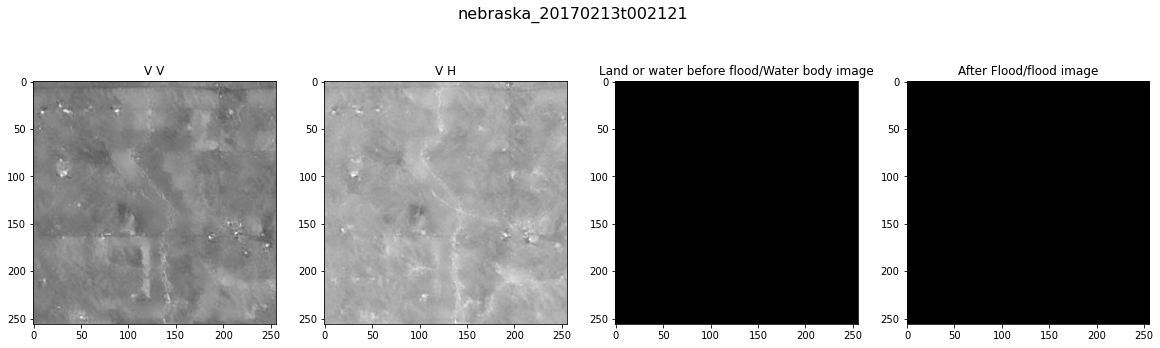

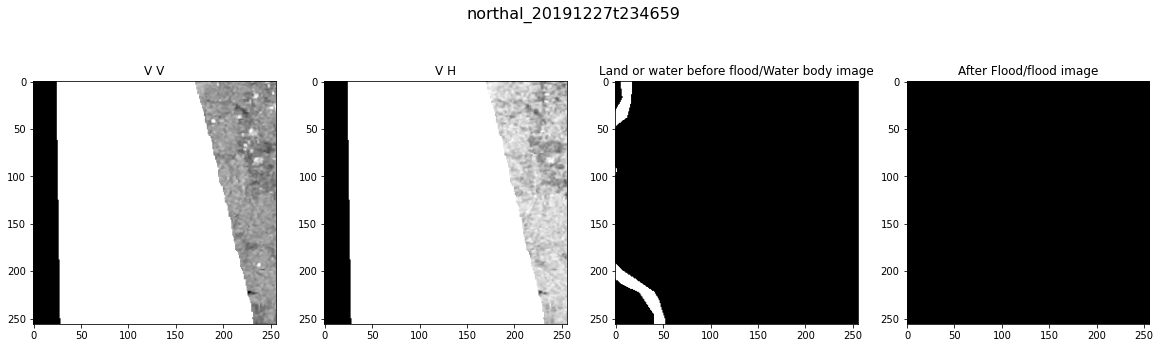

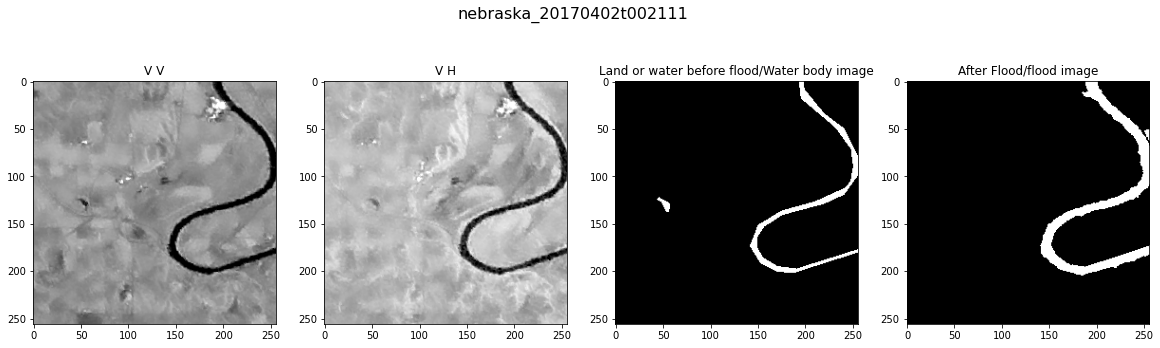

In [ ]:
# Without Speckle

for i in random_index:
    show_all_four_images([vv_image_paths[i], vh_image_paths[i],  
                          water_body_label_paths[i], flood_image_paths[i] ] , titles, False)

Seems like the Sentinel-1 images have gone through some speckle removal already. We can confirm this by examining the distribution of the histograms. 